## Applying similarity modifications based on source task

Additional experiments inspired by P2L (https://arxiv.org/abs/1908.07630) on modifying plain distances with sample size (and others).

In [2]:
import mml.interactive
mml.interactive.init()
from mml_tf.distances import LoadCachedDistances, HyperParameter, TaskDistances, get_variety, map_dist2printable, \
    get_closest
import plotly.express as px
from typing import List
from mml_tf.evaluation import get_evaluations
from mml_tf.aggregate import AggregateStrategy
from mml_tf.paths import CACHE_PATH
from mml_tf.experiments import METRICS, EXPERIMENTS
from mml_tf.visualization import get_exp_color, init_colors, get_dist_measure_color
from mml_tf.tasks import task_infos, test_tasks
import pandas as pd

/home/scholzpa/Documents/development/gitlab/mml/src/mml/interactive/__init__.py:49: UserWarning: Did not provide a "env_path", neither found set "MML_ENV_PATH" variable, you might need to provide "env_path" to "init" in order to use "mml" interactively in a jupyter/ipython setting.
  warnings.warn(
/home/scholzpa/miniconda3/envs/mml/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


 _____ ______   _____ ______   ___
|\   _ \  _   \|\   _ \  _   \|\  \
\ \  \\\__\ \  \ \  \\\__\ \  \ \  \
 \ \  \\|__| \  \ \  \\|__| \  \ \  \
  \ \  \    \ \  \ \  \    \ \  \ \  \____
   \ \__\    \ \__\ \__\    \ \__\ \_______\
    \|__|     \|__|\|__|     \|__|\|_______|
         ____  _  _    __  _  _  ____  _  _
        (  _ \( \/ )  (  )( \/ )/ ___)( \/ )
         ) _ ( )  /    )( / \/ \\___ \ )  /
        (____/(__/    (__)\_)(_/(____/(__/
Interactive MML API initialized.


In [3]:
comp_distances = [
    'SEMANTIC', # manual baseline
    'VDNA-PP:NN-1000-BINS', # VDNA paper
    'FED', # FED paper
    'FID', # Frechet Inception Distance
    'KLD-PP:NN', # P2L paper
    'KLD-PP:NS-W:TS-100-BINS', # bKLD(small,target)
    'KLD-PP:NS-W:SN-1000-BINS', # bKLD(large,source)
    'KLD-PP:NS-1000-BINS', # bKLD(large,unweighted)
]  
plot_order = [map_dist2printable[d] for d in comp_distances]
all_distances = {dist: LoadCachedDistances(dist) for dist in comp_distances if dist != 'P2L'}
init_colors(exp=EXPERIMENTS, distance_measures=plot_order)
color_map = {dist: get_dist_measure_color(dist) for dist in plot_order}
exp_color_map = {exp: get_exp_color(exp) for exp in EXPERIMENTS}
symbol_map = {d: 'circle' for d in plot_order}
symbol_map[map_dist2printable['KLD-PP:NS-W:SN-1000-BINS']] = 'hexagon'
symbol_map[map_dist2printable['KLD-PP:NS-1000-BINS']] = 'hexagram'
dash_map = {d: 'solid' for d in plot_order}
dash_map[map_dist2printable['KLD-PP:NS-W:SN-1000-BINS']] = 'dash'
dash_map[map_dist2printable['KLD-PP:NS-1000-BINS']] = 'dot'
mm_display_map = {'regret': 'regret', 'rank': 'percentile', 'delta': 'improvement', 'weightedtau': 'weightedtau', 'gain': 'fraction of improved tasks'}

In [4]:
def get_hp_distances(base_distances: List[str], weights: List[float], par: str) -> List[TaskDistances]:
    """Generates modified variants for distances based on a list of weights and the given modification parameter."""
    kwargs_map = {w: {par: w} for w in weights}
    hp_distances = []
    for dist in base_distances:
        mod_distances = {w: LoadCachedDistances(dist, hp=HyperParameter(sim=1., **kwargs), zscore_axis=0) for w, kwargs in kwargs_map.items()}
        for w, dist in mod_distances.items():
            dist.name += f'-{w:.4f}'
        hp_distances.extend(list(mod_distances.values()))
    return hp_distances

In [5]:
def get_hp_evaluations(hp_distances: List[TaskDistances]) -> pd.DataFrame:
    """Evaluates the modified task distances."""
    return get_evaluations(all_distances=hp_distances, aggregates=[AggregateStrategy.MEAN], metrics=METRICS, experiments=EXPERIMENTS, top_meta_metrics=['regret', 'rank', 'delta', 'gain'])

In [6]:
def get_hp_df(evaluations: pd.DataFrame) -> pd.DataFrame:
    """Extracts and aggregates results from the evaluation of modified task distances."""
    hp_plot_rows = []
    for group_values, group_df in evaluations.groupby(['exp', 'distances', 'meta metric']):
        exp, distances, meta = group_values
        hp = float(distances.split('-')[-1])
        base_distance = '-'.join(distances.split('-')[:-1])
        # detect negative weights
        if '--' in distances:
            hp *= -1
            base_distance = base_distance[:-1]
        if meta == 'regret':
            mean = (1 - group_df['score']).mean()
            std = (1 - group_df['score']).std()
        else:
            mean = group_df['score'].mean()
            std = group_df['score'].std()
        hp_plot_rows.append({'exp': exp, 'hp': hp, 'meta': meta, 'mean': mean, 'std': std, 'dist': base_distance})
    hp_plot_df = pd.DataFrame(hp_plot_rows).sort_values('hp')
    hp_plot_df['upper'] = hp_plot_df['mean'] + hp_plot_df['std']
    hp_plot_df['lower'] = hp_plot_df['mean'] - hp_plot_df['std']
    return hp_plot_df

In [7]:
def get_hps_plot(hp_plot_df: pd.DataFrame, meta_metric: str):
    """Plots the impact of modification (weight along x-axis) for a given meta metric (y-axis)."""
    df = hp_plot_df[hp_plot_df['meta'] == meta_metric].replace(map_dist2printable).sort_values('hp')
    fig = px.line(df, x='hp', y='mean', color='dist', template='plotly', color_discrete_map=color_map, category_orders={'exp': EXPERIMENTS, 'dist': [map_dist2printable[d] for d in comp_distances]}, markers=True, labels={'exp': 'Scenario', 'mean': mm_display_map[meta_metric], 'dist': 'Task Selection', 'hp': 'weighting factor'}, facet_col='exp', facet_col_wrap=2, facet_row_spacing=0.17, symbol='dist', symbol_map=symbol_map, line_dash='dist', line_dash_map=dash_map)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1], font_size=20))
    fig.update_layout(font_size=20, width=1200, height=600)
    return fig

In [8]:
# investigate sample size & dimension influence
weights = [-0.75, -0.5, -0.25, -0.125, -0.1, -0.075, -0.05, -0.025, 0., 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.25, 0.5, 0.75]
sam_distances = get_hp_distances(base_distances=comp_distances, weights=weights, par='sam')
# investigate dimension factor influence
dim_distances = get_hp_distances(base_distances=comp_distances, weights=weights, par='dim')

In [64]:
# this computation is expensive - precomputed results are cached can be loaded with the following cell
sam_df = get_hp_df(evaluations=get_hp_evaluations(hp_distances=sam_distances))
sam_df.to_csv(CACHE_PATH / 'sam_df.csv')
dim_df = get_hp_df(evaluations=get_hp_evaluations(hp_distances=dim_distances))
dim_df.to_csv(CACHE_PATH / 'dim_df.csv')

Calculating...: 100%|██████████| 49536/49536 [1:25:32<00:00,  9.65it/s]


In [9]:
sam_df = pd.read_csv(CACHE_PATH / 'sam_df.csv')
dim_df = pd.read_csv(CACHE_PATH / 'dim_df.csv')

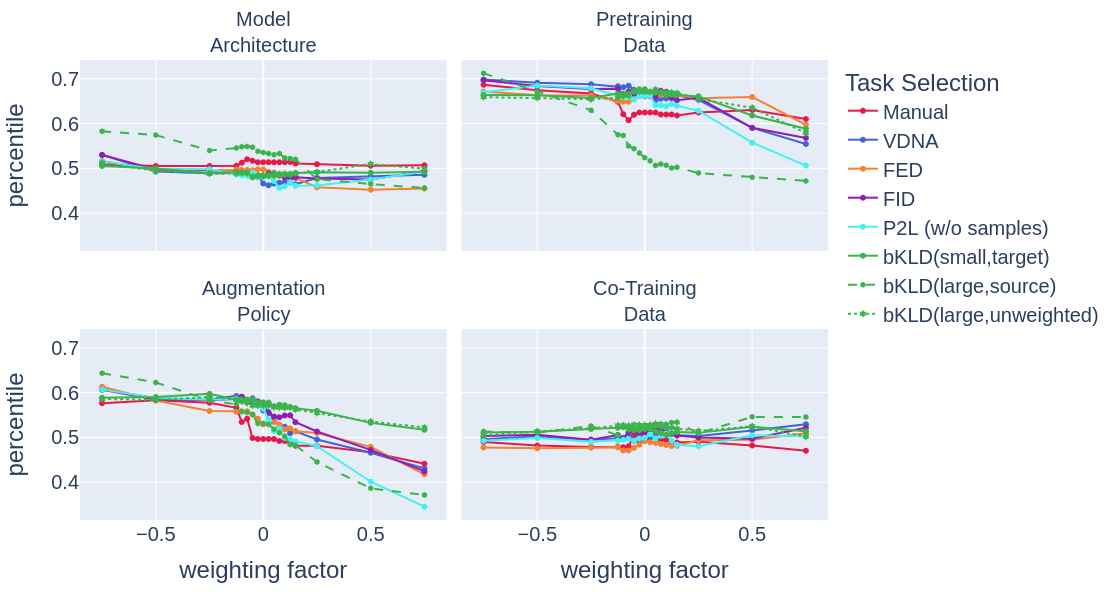

In [10]:
get_hps_plot(hp_plot_df=sam_df, meta_metric='rank')

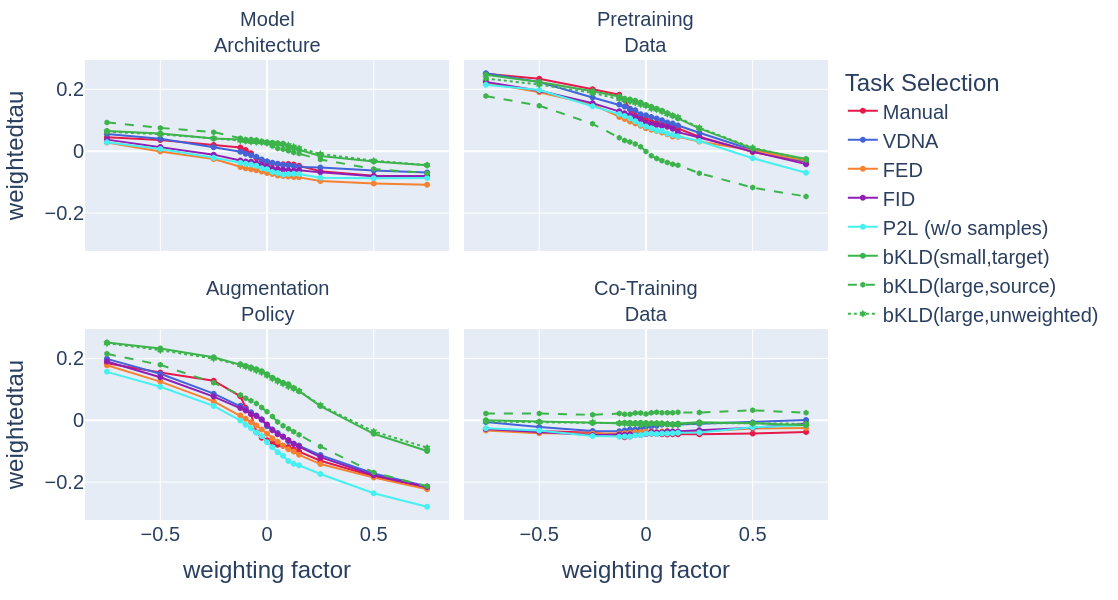

In [11]:
get_hps_plot(hp_plot_df=sam_df, meta_metric='weightedtau')

Sample size modification seems to play primarily a role in pretraining data & augmentation policy transfer. Contrary to the results by Bhattacharjee et al. (https://arxiv.org/abs/1908.07630) **preferring** smaller tasks seems to benefit there. Nevertheless, this might be highly dependent on the available set of source tasks - further experiments would be necessary with an enlarged pool of test tasks to validate that hypothesis.

In [12]:
example_distances = get_hp_distances(['KLD-PP:NS-W:TS-100-BINS'], weights= [-0.5, 0., 0.5], par='sam')

In [13]:
def show_choice_impact(task: str):
    for idx, weight in enumerate([-0.5, 0., 0.5]):
        source = get_closest(target_task=task, distances=example_distances[idx])
        print(weight, ' -> ', source, '(', task_infos.num_samples[source], ')')

In [14]:
show_choice_impact('bean_plant_disease_classification')

-0.5  ->  mednode_melanoma_classification ( 170 )
0.0  ->  laryngeal_tissues ( 1320 )
0.5  ->  isic20_melanoma_classification ( 32701 )


The above example shows the impact of modification: -0.5 puts 50% of the weight of similarity onto source size in preference of small tasks (1/3 of the overall selection weight).

In [15]:
counter = 0
for task in test_tasks:
    source_small = get_closest(target_task=task, distances=example_distances[0])
    source_large = get_closest(target_task=task, distances=example_distances[2])
    if source_small != source_large:
        counter += 1
print(counter / len(test_tasks))

0.7441860465116279


Roughly 3/4 of test tasks are affected by the change of weighting sample size negatively versus positively. 

### Incorporating source complexity

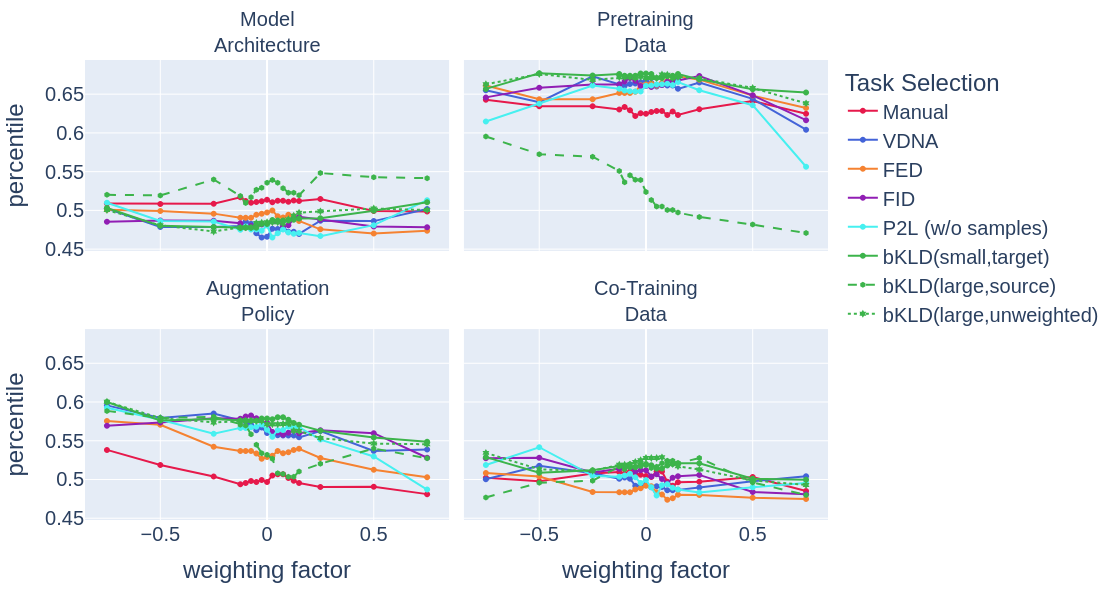

In [16]:
get_hps_plot(hp_plot_df=dim_df, meta_metric='rank')

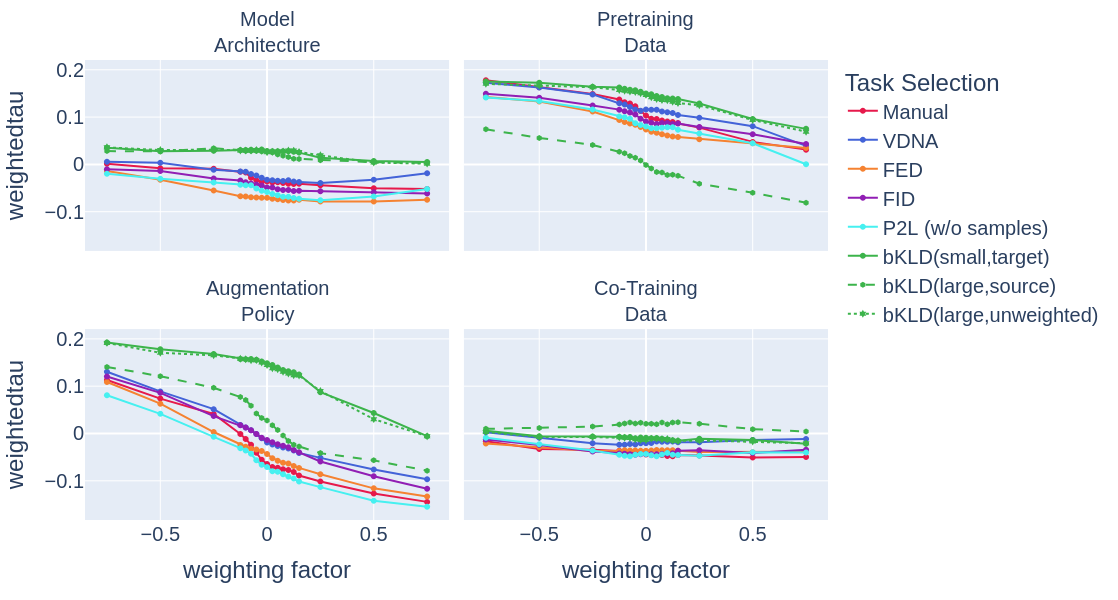

In [17]:
get_hps_plot(hp_plot_df=dim_df, meta_metric='weightedtau')

Again we observe a preference for lower dimensional source tasks. Potentially they are more generic, but the same caveat as above applies.

## Impact on source variety

In [18]:
def get_varieties_plot(distances: List[TaskDistances], shrunk: bool = True):
    """Plots the impact of modification (weight along x-axis) on the variety on source choices (keep in mind for sample size weighting at some extreme point selection would collapse to selecting the single largest/smallest source task)."""
    rows = []
    for dist in distances:
        hp = float(dist.name.split('-')[-1])
        base_distance = '-'.join(dist.name.split('-')[:-1])
        if '--' in dist.name:
            hp *= -1
            base_distance = base_distance[:-1]
        rows.append({'hp': hp, 'dist': base_distance, 'variety': get_variety(dist, shrunk=shrunk)})
    df = pd.DataFrame(rows).replace(map_dist2printable)
    fig = px.line(df, x='hp', y='variety', color='dist', template='plotly', labels={'hp': 'weighting factor', 'x': 'sample size factor', 'dist': 'Distances'}, color_discrete_map=color_map, category_orders={'exp': EXPERIMENTS, 'dist': [map_dist2printable[d] for d in comp_distances]}, markers=True, line_dash='dist', line_dash_map=dash_map, symbol='dist', symbol_map=symbol_map)
    return fig

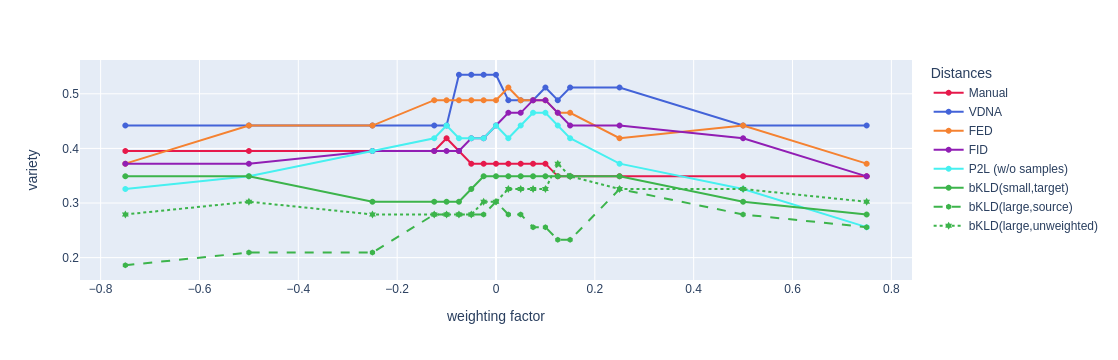

In [19]:
get_varieties_plot(sam_distances)

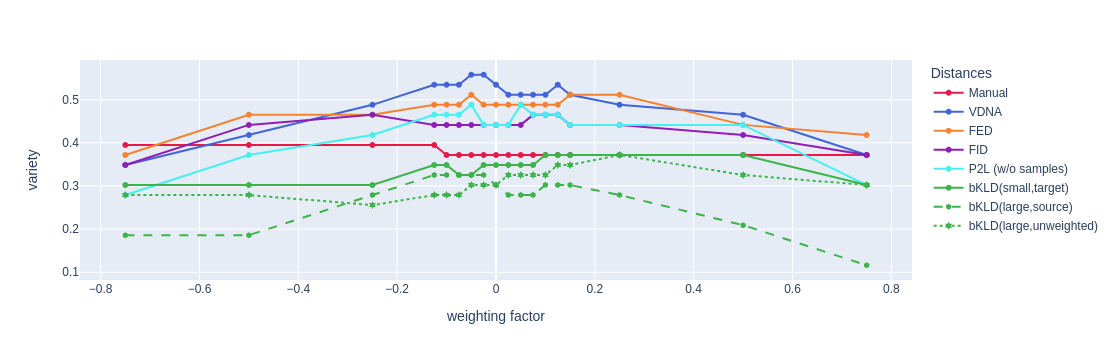

In [20]:
get_varieties_plot(dim_distances)

Apparently bKLD variants already focus on fewer source task candidates than the other task distances compared with. The bKLD(large,source) variant seems to be prone to fast collapsing to specific source tasks, which should be taken into consideration if applying modifications upon it.